## MNIST For ML Beginners 

*A tutorial from https://www.tensorflow.org/get_started/mnist/beginners*

In [2]:
from IPython.display import display, Math, Latex
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
%matplotlib inline

When one learns how to program, there's a tradition that the first thing you do is print "Hello World." Just like programming has Hello World, machine learning has MNIST.

n this tutorial, we're going to train a model to look at images and predict what digits they are. Our goal isn't to train a really elaborate model that achieves state-of-the-art performance -- although we'll give you code to do that later! -- but rather to dip a toe into using TensorFlow. As such, we're going to start with a very simple model, called a Softmax Regression.

The actual code for this tutorial is very short, and all the interesting stuff happens in just three lines. However, it is very important to understand the ideas behind it: both how TensorFlow works and the core machine learning concepts. Because of this, we are going to very carefully work through the code.

### The MNIST Data

The MNIST data is hosted on [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/). If you are copying and pasting in the code from this tutorial, start here with these two lines of code which will download and read in the data automatically:




In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The MNIST data is split into three parts: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation). This split is very important: it's essential in machine learning that we have separate data which we don't learn from so that we can make sure that what we've learned actually generalizes!

As mentioned earlier, every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. We'll call the images "x" and the labels "y". Both the training set and test set contain images and their corresponding labels; for example the training images are mnist.train.images and the training labels are mnist.train.labels.

Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers.

We can flatten this array into a vector of 28x28 = 784 numbers. It doesn't matter how we flatten the array, as long as we're consistent between images. From this perspective, the MNIST images are just a bunch of points in a 784-dimensional vector space, with a [very rich structure](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) (warning: computationally intensive visualizations).

Flattening the data throws away information about the 2D structure of the image. Isn't that bad? Well, the best computer vision methods do exploit this structure, and we will in later tutorials. But the simple method we will be using here, a softmax regression (defined below), won't.

The result is that **mnist.train.images** is a tensor (an n-dimensional array) with a shape of [55000, 784]. The first dimension is an index into the list of images and the second dimension is the index for each pixel in each image. Each entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

Each image in MNIST has a corresponding label, a number between 0 and 9 representing the digit drawn in the image.

For the purposes of this tutorial, we're going to want our labels as "one-hot vectors". A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the
th digit will be represented as a vector which is 1 in the th dimension. For example, 3 would be [0,0,0,1,0,0,0,0,0,0]. Consequently, mnist.train.labels is a [55000, 10] array of floats.

We're now ready to actually make our model!

### Softmax Regressions

We know that every image in MNIST is of a handwritten digit between zero and nine. So there are only ten possible things that a given image can be. We want to be able to look at an image and give the probabilities for it being each digit. For example, our model might look at a picture of a nine and be 80% sure it's a nine, but give a 5% chance to it being an eight (because of the top loop) and a bit of probability to all the others because it isn't 100% sure.

This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do, because softmax gives us a list of values between 0 and 1 that add up to 1. Even later on, when we train more sophisticated models, the final step will be a layer of softmax.

A softmax regression has two steps: first we add up the evidence of our input being in certain classes, and then we convert that evidence into probabilities.

To tally up the evidence that a given image is in a particular class, we do a weighted sum of the pixel intensities. The weight is negative if that pixel having a high intensity is evidence against the image being in that class, and positive if it is evidence in favor.

The following diagram shows the weights one model learned for each of these classes. Red represents negative weights, while blue represents positive weights.

We also add some extra evidence called a bias. Basically, we want to be able to say that some things are more likely independent of the input. The result is that the evidence for a class i-given an input x is:

In [5]:
%%latex

$\text{evidence}_i = \sum_j W_{i,~ j} x_j + b_i$

<IPython.core.display.Latex object>

where is *W* the weights and *b* is the bias for class , *i* and *j* is an index for summing over the pixels in our input image *x*. We then convert the evidence tallies into our predicted probabilities *y* using the "softmax" function:

In [6]:
%%latex
$y = \text{softmax}(\text{evidence})$

<IPython.core.display.Latex object>

Here softmax is serving as an "activation" or "link" function, shaping the output of our linear function into the form we want -- in this case, a probability distribution over 10 cases. You can think of it as converting tallies of evidence into probabilities of our input being in each class. It's defined as:

In [7]:
%%latex
$\text{softmax}(x) = \text{normalize}(\exp(x))$

<IPython.core.display.Latex object>

If you expand that equation out, you get:

In [8]:
%%latex
$\text{softmax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$

<IPython.core.display.Latex object>

But it's often more helpful to think of softmax the first way: exponentiating its inputs and then normalizing them. The exponentiation means that one more unit of evidence increases the weight given to any hypothesis multiplicatively. And conversely, having one less unit of evidence means that a hypothesis gets a fraction of its earlier weight. No hypothesis ever has zero or negative weight. Softmax then normalizes these weights, so that they add up to one, forming a valid probability distribution. (To get more intuition about the softmax function, check out the [section](http://neuralnetworksanddeeplearning.com/chap3.html#softmax) on it in Michael Nielsen's book, complete with an interactive visualization.)

### Implementing the Regression

To do efficient numerical computing in Python, we typically use libraries like [NumPy](http://www.numpy.org/) that do expensive operations such as matrix multiplication outside Python, using highly efficient code implemented in another language. Unfortunately, there can still be a lot of overhead from switching back to Python every operation. This overhead is especially bad if you want to run computations on GPUs or in a distributed manner, where there can be a high cost to transferring data.

TensorFlow also does its heavy lifting outside Python, but it takes things a step further to avoid this overhead. Instead of running a single expensive operation independently from Python, TensorFlow lets us describe a graph of interacting operations that run entirely outside Python. (Approaches like this can be seen in a few machine learning libraries.)

To use TensorFlow, first we need to import it.


In [9]:
import tensorflow as tf

We describe these interacting operations by manipulating symbolic variables. Let's create one:

In [10]:
x = tf.placeholder(tf.float32, [None, 784])

x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation. We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. We represent this as a 2-D tensor of floating-point numbers, with a shape [None, 784]. (Here None means that a dimension can be of any length.)

We also need the weights and biases for our model. We could imagine treating these like additional inputs, but TensorFlow has an even better way to handle it: Variable. A Variable is a modifiable tensor that lives in TensorFlow's graph of interacting operations. It can be used and even modified by the computation. For machine learning applications, one generally has the model parameters be Variables.

In [11]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

We create these Variables by giving tf.Variable the initial value of the Variable: in this case, we initialize both W and b as tensors full of zeros. Since we are going to learn W and b, it doesn't matter very much what they initially are.

Notice that W has a shape of [784, 10] because we want to multiply the 784-dimensional image vectors by it to produce 10-dimensional vectors of evidence for the difference classes. b has a shape of [10] so we can add it to the output.

We can now implement our model. It only takes one line to define it!

In [12]:
y = tf.nn.softmax(tf.matmul(x, W) + b)

First, we multiply x by W with the expression tf.matmul(x, W). This is flipped from when we multiplied them in our equation, where we had *Wx*, as a small trick to deal with x being a 2D tensor with multiple inputs. We then add b, and finally apply **tf.nn.softmax**.

That's it. It only took us one line to define our model, after a couple short lines of setup. That isn't because TensorFlow is designed to make a softmax regression particularly easy: it's just a very flexible way to describe many kinds of numerical computations, from machine learning models to physics simulations. And once defined, our model can be run on different devices: your computer's CPU, GPUs, and even phones!

### Training

In order to train our model, we need to define what it means for the model to be good. Well, actually, in machine learning we typically define what it means for a model to be bad. We call this the cost, or the loss, and it represents how far off our model is from our desired outcome. We try to minimize that error, and the smaller the error margin, the better our model is.

One very common, very nice function to determine the loss of a model is called "cross-entropy." Cross-entropy arises from thinking about information compressing codes in information theory but it winds up being an important idea in lots of areas, from gambling to machine learning. It's defined as:

In [13]:
%%latex
$H_{y'}(y) = -\sum_i y'_i \log(y_i)$

<IPython.core.display.Latex object>

Where is our predicted probability distribution, and

is the true distribution (the one-hot vector with the digit labels). In some rough sense, the cross-entropy is measuring how inefficient our predictions are for describing the truth. Going into more detail about cross-entropy is beyond the scope of this tutorial, but it's well worth [understanding](http://colah.github.io/posts/2015-09-Visual-Information/).

To implement cross-entropy we need to first add a new placeholder to input the correct answers:



In [14]:
y_ = tf.placeholder(tf.float32, [None, 10])

Then we can implement the cross-entropy function:


In [15]:
%%latex
$-\sum y'\log(y)$

<IPython.core.display.Latex object>

In [16]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

First, tf.log computes the logarithm of each element of y. Next, we multiply each element of y\_ with the corresponding element of tf.log(y). Then tf.reduce_sum adds the elements in the second dimension of y, due to the reduction_indices=[1] parameter. Finally, tf.reduce_mean computes the mean over all the examples in the batch.

Note that in the source code, we don't use this formulation, because it is numerically unstable. Instead, we apply tf.nn.softmax_cross_entropy_with_logits on the unnormalized logits (e.g., we call softmax_cross_entropy_with_logits on tf.matmul(x, W) + b), because this more numerically stable function internally computes the softmax activation. In your code, consider using tf.nn.softmax_cross_entropy_with_logits instead.

Now that we know what we want our model to do, it's very easy to have TensorFlow train it to do so. Because TensorFlow knows the entire graph of your computations, it can automatically use the [backpropagation algorithm](http://colah.github.io/posts/2015-08-Backprop/) to efficiently determine how your variables affect the loss you ask it to minimize. Then it can apply your choice of optimization algorithm to modify the variables and reduce the loss.

In [17]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In this case, we ask TensorFlow to minimize cross_entropy using the [gradient descent algorithm](https://en.wikipedia.org/wiki/Gradient_descent) with a learning rate of 0.5. Gradient descent is a simple procedure, where TensorFlow simply shifts each variable a little bit in the direction that reduces the cost. But TensorFlow also provides [many other optimization algorithms](https://www.tensorflow.org/api_guides/python/train#Optimizers): using one is as simple as tweaking one line.

What TensorFlow actually does here, behind the scenes, is to add new operations to your graph which implement backpropagation and gradient descent. Then it gives you back a single operation which, when run, does a step of gradient descent training, slightly tweaking your variables to reduce the loss.

We can now launch the model in an InteractiveSession:

In [18]:
sess = tf.InteractiveSession()

We first have to create an operation to initialize the variables we created:

In [19]:
tf.global_variables_initializer().run()

Let's train -- we'll run the training step 1000 times!

In [20]:
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})


In [21]:
batch_xs, batch_ys = mnist.train.next_batch(1)
print mnist.train.next_batch(1)

(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.

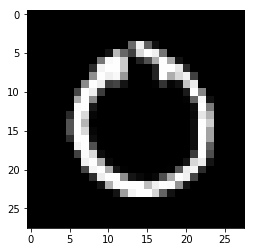

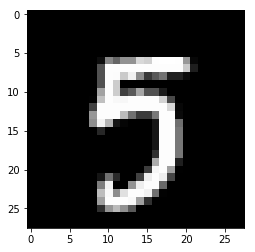

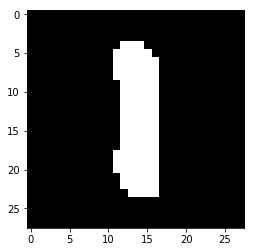

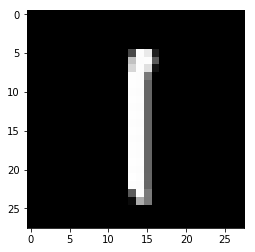

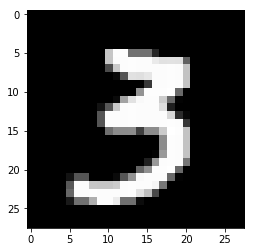

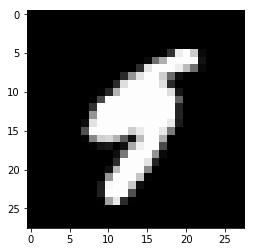

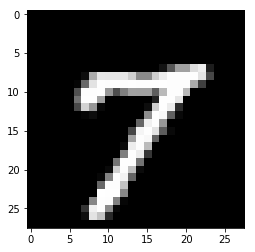

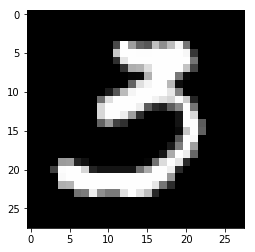

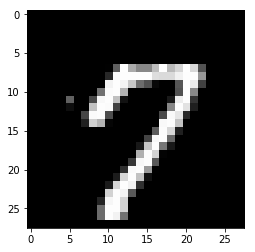

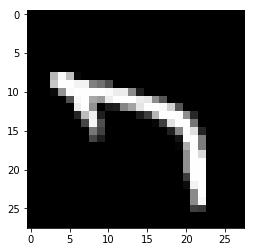

In [38]:
for i in range(10):
    image = np.array(mnist.train.images[i*1000,:])
    image = image.reshape((28, 28))
    plt.imshow(image, cmap='gray')
    plt.show()

Each step of the loop, we get a "batch" of one hundred random data points from our training set. We run train_step feeding in the batches data to replace the placeholders.

Using small batches of random data is called stochastic training -- in this case, stochastic gradient descent. Ideally, we'd like to use all our data for every step of training because that would give us a better sense of what we should be doing, but that's expensive. So, instead, we use a different subset every time. Doing this is cheap and has much of the same benefit.

### Evaluating Our Model

How well does our model do?

Well, first let's figure out where we predicted the correct label. tf.argmax is an extremely useful function which gives you the index of the highest entry in a tensor along some axis. For example, tf.argmax(y,1) is the label our model thinks is most likely for each input, while tf.argmax(y_,1) is the correct label. We can use tf.equal to check if our prediction matches the truth.



In [ ]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

That gives us a list of booleans. To determine what fraction are correct, we cast to floating point numbers and then take the mean. For example, [True, False, True, True] would become [1,0,1,1] which would become 0.75.


In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Finally, we ask for our accuracy on our test data.

In [ ]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

This should be about 92%.

Is that good? Well, not really. In fact, it's pretty bad. This is because we're using a very simple model. With some small changes, we can get to 97%. The best models can get to over 99.7% accuracy! (For more information, have a look at this [list of results](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html).)